##Git Clone
Clone the github repository to be able to access the dataset as it is uploaded to the repository

In [1]:
!git clone https://github.com/KaleF07/WasteClassification.git

Cloning into 'WasteClassification'...
remote: Enumerating objects: 24818, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 24818 (delta 17), reused 20 (delta 7), pack-reused 24779
Receiving objects: 100% (24818/24818), 358.70 MiB | 34.68 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (50158/50158), done.


##INSTALLATIONS

In [2]:
!pip install -Uqq fastbook
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.9 MB/s eta 0:00:00


##IMPORTS

In [2]:
import os
from fastai.vision.widgets import *
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import datasets, layers, models, Model
import matplotlib.pyplot as plt
import time
import tempfile
import numpy as np
from fastai.vision.all import Learner

##DATA LOADING & AUGMENTATION

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Step 2: Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1,  # randomly shift images vertically by 10%
    zoom_range=0.1,  # randomly zoom into images by 10%
    brightness_range=[0.5, 1.5],  # randomly adjust brightness between 0.5 and 1.5
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not flip images vertically
    rescale=1./255  # rescale pixel values to the range [0, 1]
)

# Step 3: Load data
train_generator = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TRAIN',  # path to the training data directory
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)

validation_generator = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TEST',  # path to the validation data directory
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


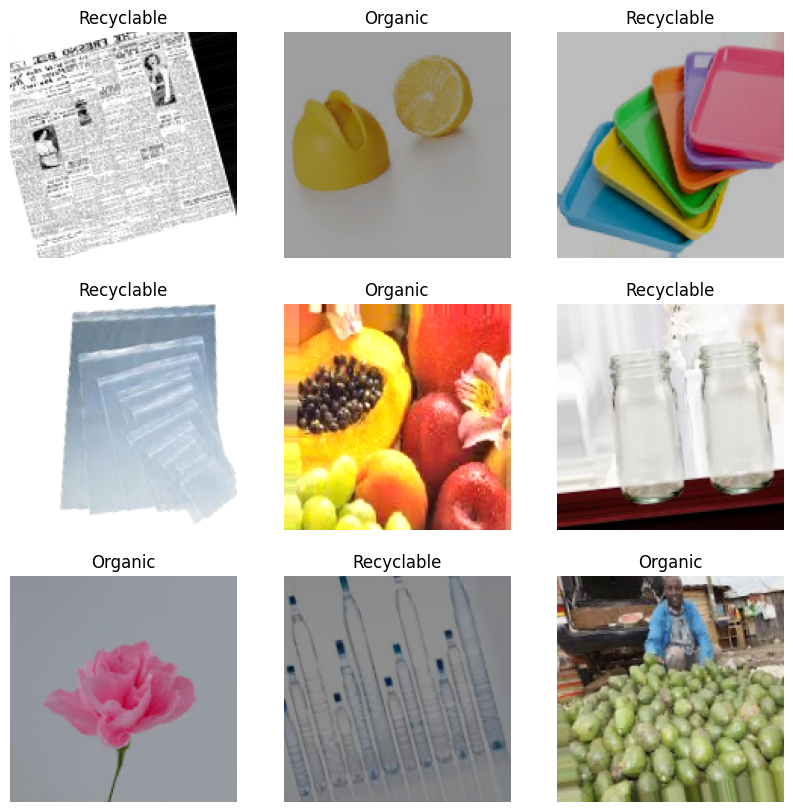

In [5]:
# Get a batch of images and labels from the generator
batch_images, batch_labels = next(train_generator)  # or validation_generator

# Define class names
class_names = ['Organic', 'Recyclable']

# Display the first few images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch_images[i])
    plt.title('{}'.format(class_names[int(batch_labels[i])]))
    plt.axis('off')
plt.show()

In [6]:
# Load MobileNet model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Add a classification layer with the number of classes in your dataset
predictions = Dense(2, activation='softmax')(x)

# Combine the base model with the new layers
base_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

<ipython-input-29-746f62817607>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobilemodel.fit_generator(


Epoch 1/10
706/706 [==============================] - 148s 188ms/step - loss: 0.4499 - accuracy: 0.8082 - val_loss: 0.3925 - val_accuracy: 0.8468
Epoch 2/10
706/706 [==============================] - 133s 188ms/step - loss: 0.3793 - accuracy: 0.8431 - val_loss: 0.3951 - val_accuracy: 0.8635
Epoch 3/10
706/706 [==============================] - 132s 187ms/step - loss: 0.3522 - accuracy: 0.8540 - val_loss: 0.7421 - val_accuracy: 0.7823
Epoch 4/10
706/706 [==============================] - 134s 190ms/step - loss: 0.3306 - accuracy: 0.8646 - val_loss: 0.5101 - val_accuracy: 0.8201
Epoch 5/10
706/706 [==============================] - 133s 188ms/step - loss: 0.3325 - accuracy: 0.8614 - val_loss: 0.3284 - val_accuracy: 0.8762
Epoch 6/10
706/706 [==============================] - 133s 189ms/step - loss: 0.3199 - accuracy: 0.8682 - val_loss: 0.3918 - val_accuracy: 0.8492
Epoch 7/10
706/706 [==============================] - 133s 189ms/step - loss: 0.3065 - accuracy: 0.8748 - val_loss: 0.2568 -

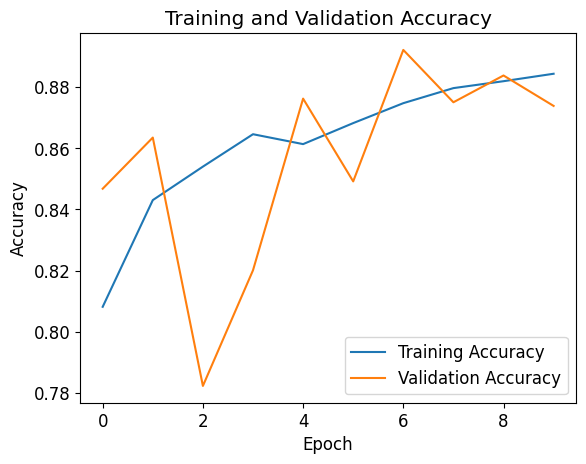

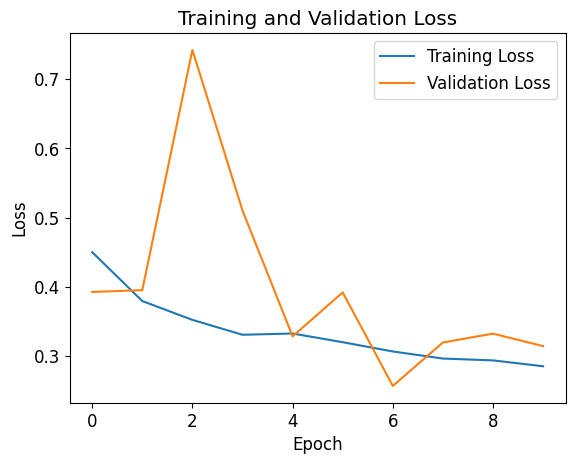

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
base_model.save('mobilenet_model.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('mobilenet_model.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = base_model.predict(validation_generator)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator)

print("Inference time per sample:", inference_time_per_sample, "seconds")

Model size: 40618784 bytes
79/79 [==============================] - 13s 168ms/step
Inference time per sample: 0.1720262599896781 seconds


In [ ]:
def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)

    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    if strides != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    out = layers.Add()([x, y])
    out = layers.Activation(activation)(out)
    return out

def ResNet(input_shape=(32, 32, 3), num_classes=10, num_blocks_list=[3, 4, 6, 3], base_filters=64):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(base_filters, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for i, num_blocks in enumerate(num_blocks_list):
        filters = base_filters * (2**i)
        strides = 1 if i == 0 else 2

        for _ in range(num_blocks):
            x = residual_block(x, filters=filters, strides=strides)
            strides = 1

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
resnet_model = ResNet(input_shape=(150, 150, 3), num_classes=2, num_blocks_list=[4, 5, 6, 4], base_filters=64)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = resnet_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

<ipython-input-37-84dcab81621a>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet_model.fit_generator(


Epoch 1/10
706/706 [==============================] - 160s 192ms/step - loss: 0.5402 - accuracy: 0.7894 - val_loss: 0.7549 - val_accuracy: 0.7632
Epoch 2/10
706/706 [==============================] - 135s 191ms/step - loss: 0.4311 - accuracy: 0.8119 - val_loss: 0.5285 - val_accuracy: 0.7517
Epoch 3/10
706/706 [==============================] - 134s 190ms/step - loss: 0.4043 - accuracy: 0.8279 - val_loss: 0.3839 - val_accuracy: 0.8520
Epoch 4/10
706/706 [==============================] - 135s 191ms/step - loss: 0.3767 - accuracy: 0.8377 - val_loss: 0.3159 - val_accuracy: 0.8731
Epoch 5/10
706/706 [==============================] - 135s 191ms/step - loss: 0.3741 - accuracy: 0.8439 - val_loss: 0.3034 - val_accuracy: 0.8878
Epoch 6/10
706/706 [==============================] - 134s 190ms/step - loss: 0.3589 - accuracy: 0.8503 - val_loss: 0.4495 - val_accuracy: 0.8460
Epoch 7/10
706/706 [==============================] - 134s 190ms/step - loss: 0.3489 - accuracy: 0.8535 - val_loss: 0.4949 -

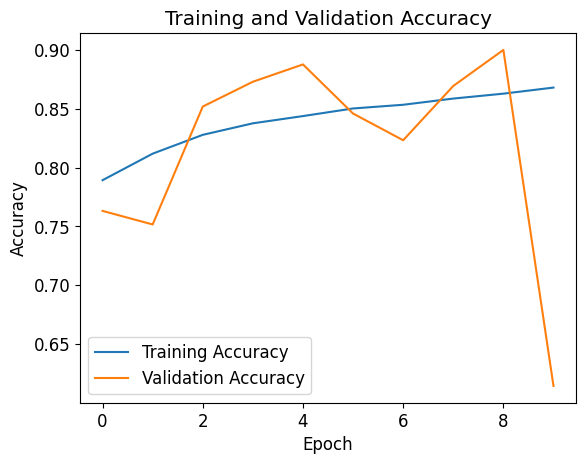

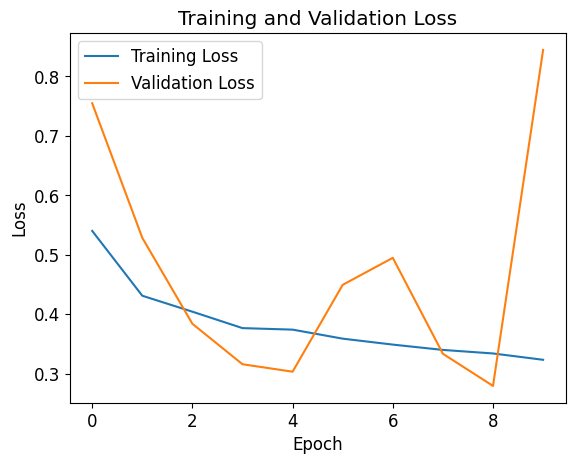

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
resnet_model.save('resnet_model.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('resnet_model.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = resnet_model.predict(validation_generator)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator)

print("Inference time per sample:", inference_time_per_sample, "seconds")

Model size: 317400264 bytes
79/79 [==============================] - 14s 171ms/step
Inference time per sample: 0.1747199915632417 seconds


In [5]:
# Build the model
Tiny_model = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer for data of shape (150, 150, 3)
    Flatten(),  # Flatten the input image
    Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    Dense(2, activation='softmax')  # Output layer with 10 units for 10 classes (digits 0-9)
])

# Compile the model
Tiny_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Tiny_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 8640386 (32.96 MB)
Trainable params: 8640386 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
history = Tiny_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

<ipython-input-6-88e50eaaf6ac>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Tiny_model.fit_generator(


Epoch 1/10
706/706 [==============================] - 142s 199ms/step - loss: 1.0560 - accuracy: 0.7495 - val_loss: 0.4391 - val_accuracy: 0.8217
Epoch 2/10
706/706 [==============================] - 142s 201ms/step - loss: 0.4812 - accuracy: 0.7849 - val_loss: 0.3808 - val_accuracy: 0.8345
Epoch 3/10
706/706 [==============================] - 142s 202ms/step - loss: 0.4712 - accuracy: 0.7872 - val_loss: 0.4746 - val_accuracy: 0.8126
Epoch 4/10
706/706 [==============================] - 143s 202ms/step - loss: 0.4690 - accuracy: 0.7909 - val_loss: 0.4042 - val_accuracy: 0.8532
Epoch 5/10
706/706 [==============================] - 144s 204ms/step - loss: 0.4676 - accuracy: 0.7913 - val_loss: 0.4166 - val_accuracy: 0.8432
Epoch 6/10
706/706 [==============================] - 143s 203ms/step - loss: 0.4662 - accuracy: 0.7922 - val_loss: 0.3914 - val_accuracy: 0.8556
Epoch 7/10
706/706 [==============================] - 143s 203ms/step - loss: 0.4666 - accuracy: 0.7936 - val_loss: 0.4228 -

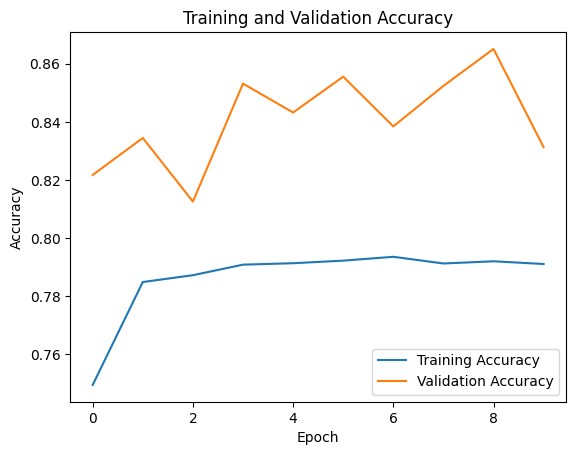

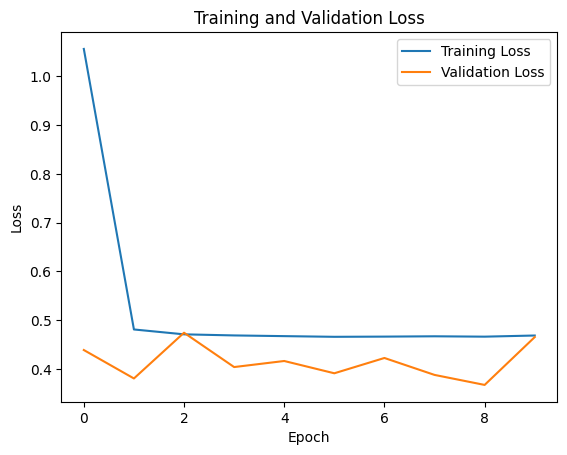

In [7]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Save the model to disk
Tiny_model.save('Tiny_model.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('Tiny_model.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = Tiny_model.predict(validation_generator)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator)

print("Inference time per sample:", inference_time_per_sample, "seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model size: 103710544 bytes
79/79 [==============================] - 14s 179ms/step
Inference time per sample: 0.1838533999044684 seconds


In [10]:
train_generator = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TRAIN',  # path to the training data directory
    target_size=(64, 64),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)

validation_generator = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TEST',  # path to the validation data directory
    target_size=(64, 64),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [11]:
# Load MobileNet model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Add a classification layer with the number of classes in your dataset
predictions = Dense(2, activation='softmax')(x)

# Combine the base model with the new layers
base_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

Epoch 1/10


<ipython-input-12-4f7c36264ba9>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


706/706 [==============================] - 84s 78ms/step - loss: 0.3582 - accuracy: 0.8597 - val_loss: 1.8802 - val_accuracy: 0.4978
Epoch 2/10
706/706 [==============================] - 52s 74ms/step - loss: 0.2777 - accuracy: 0.8935 - val_loss: 3.5689 - val_accuracy: 0.5042
Epoch 3/10
706/706 [==============================] - 52s 74ms/step - loss: 0.2603 - accuracy: 0.8997 - val_loss: 1.0668 - val_accuracy: 0.7887
Epoch 4/10
706/706 [==============================] - 52s 74ms/step - loss: 0.2429 - accuracy: 0.9039 - val_loss: 0.7141 - val_accuracy: 0.7875
Epoch 5/10
706/706 [==============================] - 53s 74ms/step - loss: 0.2355 - accuracy: 0.9083 - val_loss: 0.9442 - val_accuracy: 0.7927
Epoch 6/10
706/706 [==============================] - 52s 74ms/step - loss: 0.2289 - accuracy: 0.9143 - val_loss: 0.5208 - val_accuracy: 0.8687
Epoch 7/10
706/706 [==============================] - 52s 74ms/step - loss: 0.2333 - accuracy: 0.9105 - val_loss: 0.8562 - val_accuracy: 0.7911
Epo

In [7]:
train_generator_64 = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TRAIN',  # path to the training data directory
    target_size=(150, 150),  # resize images to 224x224
    batch_size=64,  # batch size
    class_mode='binary'  # binary classification
)

validation_generator_64 = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TEST',  # path to the validation data directory
    target_size=(150, 150),  # resize images to 224x224
    batch_size=64,  # batch size
    class_mode='binary'  # binary classification
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model.fit_generator(
    train_generator_64,  # training data generator
    steps_per_epoch=len(train_generator_64),
    epochs=10,
    validation_data=validation_generator_64,  # validation data generator
    validation_steps=len(validation_generator_64)
)

<ipython-input-8-7488fdbf8e20>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


193/353 [===============>..............] - ETA: 9:10 - loss: 0.2874 - accuracy: 0.8895

KeyboardInterrupt: 

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
load_model = tf.keras.models.load_model('/content/WasteClassification/mobilenet_model.h5', compile=True)

In [ ]:
# Convert model from type Functional to Sequential
mobilenet_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  mobilenet_model.add(layer)

In [ ]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32)        128       
 zation)                                                         
                                                        

In [ ]:
# Apply one-shot pruning
def apply_pruning(model, target_sparsity):
  # Prune model with target sparsity
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning. The sparsity is the target sparsity
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity, begin_step=0, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Fine tune the pruned model
  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(
      train_generator,  # training data generator
      steps_per_epoch=len(train_generator),
      epochs=2,
      validation_data=validation_generator,  # validation data generator
      validation_steps=len(validation_generator),
      callbacks=callbacks
  )


  # Strip the pruned model
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return stripped_pruned_model

def evaluate_model(sparsity):
    # Compile the model manually
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)

    return test_acc

In [ ]:
import matplotlib.pyplot as plt
sparsity_levels = [0, 0.2, 0.4, 0.6, 0.8]
accuracies = []

for target_sparsity in sparsity_levels:
    # Apply the pruning function with the current target sparsity
    pruned_mobile_model = apply_pruning(mobilenet_model, target_sparsity)

    # Assuming 'evaluate_model' is a function that returns the accuracy of the model
    accuracy = evaluate_model(mobilenet_model)
    accuracies.append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Sparsity Level')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  7/706 [..............................] - ETA: 31:30 - loss: 0.3031 - accuracy: 0.8750

KeyboardInterrupt: 